In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from nowcast_lstm.LSTM import LSTM
from nowcast_lstm.model_selection import select_model, variable_selection
import torch
import dill

In [6]:
dataframe = pd.read_excel('230315 Nowcasting Dataset.xlsx', sheet_name='Nowcasting Dataset', parse_dates=['Date'])
dataframe = dataframe.drop(
    ["GDP_QNA_PCT", "GDP_QNA_LVL_LD", "GDP_QNA_LVL"], axis=1)
dataframe["GDP_QNA_RG"] = dataframe["GDP_QNA_RG"].interpolate()
dataframe["LIBOR_3mth"] = dataframe["LIBOR_3mth"].interpolate()
before_covid = "2019-12-12"
train_end_date = "2016-01-01"
training = dataframe.loc[dataframe.Date <= train_end_date,:]
testing = dataframe.loc[dataframe.Date > train_end_date,:]
target = "GDP_QNA_RG"


In [7]:
selection_results = pd.read_csv("selection_results.csv")
predictions_list_of_dictionaries = []
for index, row in selection_results.iterrows():
    variables = eval(row["variables"])
    variables.append("Date")
    variables.append("GDP_QNA_RG")
    hyperparameters = eval(row["hyperparameters"])

    temp_dataframe = dataframe[variables]
    temp_training = temp_dataframe.loc[lambda x: x.Date <= train_end_date]
    model = LSTM(
        temp_training,
        target,
        hyperparameters["n_timesteps"],
        n_models=hyperparameters["n_models"],
        train_episodes=hyperparameters["train_episodes"],
        batch_size=hyperparameters["batch_size"],
        decay=hyperparameters["decay"],
        n_hidden=hyperparameters["n_hidden"],
        n_layers=hyperparameters["n_layers"],
        dropout=hyperparameters["dropout"],
    )
    model.train(quiet=True)

    temp_predictions = model.predict(temp_dataframe).loc[
        lambda x: x.date > train_end_date
    ]
    MSE = np.mean((temp_predictions.actuals - temp_predictions.predictions) ** 2)
    variables.pop(variables.index("Date"))
    variables.pop(variables.index("GDP_QNA_RG"))

    predictions_list_of_dictionaries.append(
        {"predictions": temp_predictions, "mse": MSE, "variables": variables}
    )

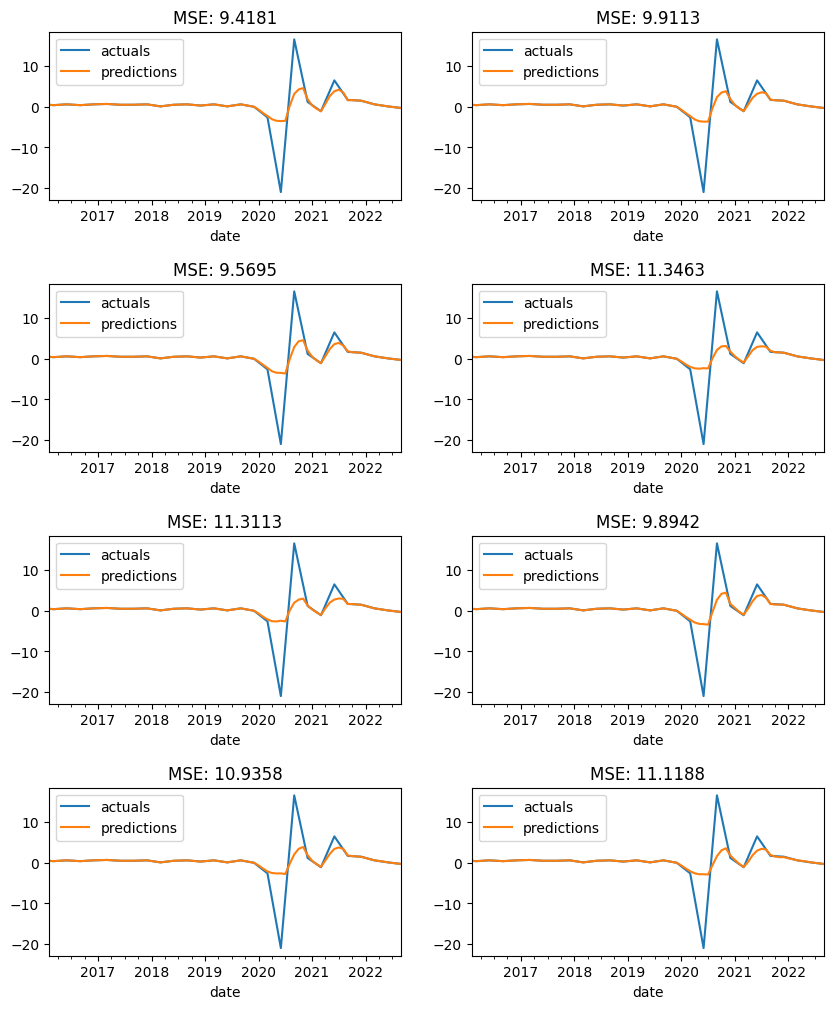

In [9]:
fig3, axes = plt.subplots(4, 2, sharey=False, sharex=False, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)

for prediction, ax in zip(predictions_list_of_dictionaries, axes.ravel()):
    pred_df = pd.DataFrame.from_dict(prediction["predictions"])
    pred_df.plot(ax=ax, x="date")
    ax.set_title(f"MSE: {np.round(prediction['mse'],4)}")

fig3.savefig("with_covid.png")